# The current LEO population
The US government provides GP or general perturbations orbital data for all Earth orbiing satellites as produced from the [US Space Surveillance Network (SSN)](https://en.wikipedia.org/wiki/United_States_Space_Surveillance_Network). These are in the form of Brouwer mean elements to be used in the SGP4 or [Simplified General Perturbations 4 orbit propagator](https://en.wikipedia.org/wiki/Simplified_perturbations_models). 

Together with the Brouwer mean elements, information on the objects [BSTAR](https://en.wikipedia.org/wiki/BSTAR) cefficient is made available and hence on the drag force acting upon it. Some (limited) information on the objects radar cross section (RCS) is also available. 

Using this data, plausible initial conditions of all the tracked objects can be computed and used to simulte the possible evolutions of the currently known population. In the following, we will see how this can be achieved with Python code. 

Start with the necessary imports:


In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl

import sgp4
from sgp4.api import Satrec, SatrecArray

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## Extracting the data on the currently tracked population

We will here make combined use of two files that are distributed by the USSPACECOM. Most of the data contained in the files is derived from observations of the [United States Space Surveillance Network](https://en.wikipedia.org/wiki/United_States_Space_Surveillance_Network).

The files are named:
* [satcat.txt](https://celestrak.com/satcat/search.php) downloaded from [celestrack](https://celestrak.com) on January 2022
* [satcat.json](https://www.space-track.org/basicspacedata/query/class/gp/decay_date/null-val/epoch/%3Enow-30/orderby/norad_cat_id/format/json) downloaded from [space-track](https://celestrak.com) on January 2022

The reason to use both is that, at the time of writing, they contain complementary information. While both contain the tracked objects' Brouwer mean elements and their [BSTAR](https://en.wikipedia.org/wiki/BSTAR), the information on the radar cross section (RCS) is only given for some satellites in the "old" satcat.txt. For those objects that do not have such an information, the json file reports, at least, a generic "SMALL", "MEDIUM", "LARGE" category that can be used to assign to the object a dimension (useful in simulations where detected collisions result in break-ups based on the impact energy).

Note that the remaining code is written to work with the two files as downloaded in February 2022. We have obtained permission from the SSA Partnership and Coalition Engagement (SPACE) Office (US) to share these, now old, files via the cascade code so that you do not have to download them yorself. In case you do wat to play with the latest versions, you will need a user in the [space-track](https://celestrak.com) website.

Lets start importing the files:

In [2]:
# Import the "old" SATCAT
satcat_old = pk.util.read_satcat("data/satcat.txt")
# Import the json catalogue
with open("data/satcat.json", "r") as file:
    satcat = json.load(file)
print("Satellites number in satcat (json): ", len(satcat))
print("Satellites number in satcat_old (txt): ", len(satcat_old))

Satellites number in satcat (json):  23947
Satellites number in satcat_old (txt):  51407


A different number of objects in the two datsets is expected as the txt (stacat_old) contains also all past decayed objects, while the json file (satcat) contains only the orbiting ones (at the time of download).

We then add to the corresponding dictionary an estimate of each object radius in meters.

In [3]:
# We add to the JSON entries their estimated radius (key: RADIUS)
count = 0
for object in satcat:
    key = object["OBJECT_ID"]
    if key in satcat_old and key !='' and satcat_old[key].radarA.strip() != "N/A":
        radius = np.sqrt(float(satcat_old[key].radarA)/np.pi)
        count+=1
    else:
        if object["RCS_SIZE"] == "SMALL":
            radius = 0.15
        elif object["RCS_SIZE"] == "MEDIUM":
            radius = 0.55
        else:
            radius = 2.
    object["RADIUS"] = radius
print("Number of objects with radius estimated from satcat_old: ", count)
print("Number of objects with radius estimated from satcat: ", len(satcat) - count)

Number of objects with radius estimated from satcat_old:  15941
Number of objects with radius estimated from satcat:  8006


In order to maintain a correspondence between the satcat and the various propagated particles we use, and keep updated, the following array:

In [4]:
to_satcat_index = np.arange(len(satcat))
print("Number of satellites left in the simulation: ", len(to_satcat_index))


Number of satellites left in the simulation:  23947


so that, if ```r[j]``` contains the position of an object, ```satcat(to_satcat_index[j])``` will be the corresponding satcat entry. This book keeping is made necessary as objects will be removed for several reasons from the simulation (decayed, exploded, etc..)

We are now ready to compute the various object positions at a choosen starting epoch. We will use here the reference epoch 2022-Mar-01 since our files where downloaded at the beginning of 2022. We also use the vectorized version of the SGP4 propagator, hence
building first a SatrecArray object (see [sgp4 module documentation](https://pypi.org/project/sgp4/)).

In [5]:
# We call the SGP4 propagator to a common initial epoch
jd = pk.epoch_from_iso_string("20220301T000000").jd # Julian date corresponding to 2022-Mar-01 00:00:00
sgp4_objects_l = []
for i, object in enumerate(satcat):
    l1 = object["TLE_LINE1"]
    l2 = object["TLE_LINE2"]
    sgp4_objects_l.append(Satrec.twoline2rv(l1, l2))
sgp4_objects = SatrecArray(sgp4_objects_l)
err, r, v = sgp4_objects.sgp4(np.array([2459639.5]), np.array([0.]))
# Reshaping to remove the middle dimension (its 1 anyway)
dims = np.shape(r)
r = np.reshape(r, (dims[0],dims[2]))
v = np.reshape(v, (dims[0],dims[2]))


Some of the orbiting objects did not make it to 2022-Mar-01 as they have re-entered the Earth atmosphere. Lets count and remove them. First we use the error code from sgp4 to detect decayed  objects:

In [6]:
# We remove the decayed objects
mask = np.where(err!=0)[0]
for idx in mask[::-1]:
    r = np.delete(r, idx, axis=0)
    v = np.delete(v, idx, axis=0)
    to_satcat_index = np.delete(to_satcat_index, idx, axis=0)
print("Number of objects decayed: ", len(mask))
print("Number of satellites in the simulation: ", len(to_satcat_index))

Number of objects decayed:  79
Number of satellites in the simulation:  23868


And then we filter the objects using their the semimajor axis computed at the epoch ```jd```. This will remove objects that are not LEO as well as those that have been wrongly propgagated by sgp4 well past their decay epoch.

In [7]:
# We remove other decayed objects computing the orbital elements at jd and filtering again
sma, ecc, incl = [], [], []
counter=0
for pos,vel in zip(r,v):
    elements = pk.ic2par(pos*1000,vel*1000,pk.MU_EARTH)
    sma.append(elements[0]/1000) 
    ecc.append(elements[1])
    incl.append(elements[2] / np.pi * 180) 

mask = np.where(np.array(sma)>10000)[0]
for idx in mask[::-1]:
    r = np.delete(r, idx, axis=0)
    v = np.delete(v, idx, axis=0)
    to_satcat_index = np.delete(to_satcat_index, idx, axis=0)
    sma = np.delete(sma, idx, axis=0)
    ecc = np.delete(ecc, idx, axis=0)
    incl = np.delete(incl, idx, axis=0)
print("Number of objects removed: ", len(mask))
print("Number of satellites in the simulation: ", len(to_satcat_index))


Number of objects removed:  4194
Number of satellites in the simulation:  19674


Finally we detect and remove objects that are co-orbiting, like payloads attached to the International Space Station and similar.

In [8]:
# First we find all unique elements in r
new_r, idx, count = np.unique(r[:,0], return_index=True, return_counts=True)
# We then ask where more than one element occur
where = np.where(count>2)[0]
# And for each entry that was not unique we retreive what objects
not_unique_lists = []
for not_unique in where:
    not_unique_lists.append(np.where(r[:,0] == r[idx[not_unique],0])[0])
# We now print on screen our findings
for not_unique in not_unique_lists:
    print("\nFound the following co-orbiting objects:")
    for idx in not_unique:
        print(satcat[to_satcat_index[idx]]["OBJECT_NAME"], "\t\twith RCS: ", satcat[to_satcat_index[idx]]["RADIUS"])


Found the following co-orbiting objects:
TIANZHOU 2 		with RCS:  2.0
TIANZHOU 3 		with RCS:  0.15
SZ-13 		with RCS:  2.0

Found the following co-orbiting objects:
ISS (NAUKA) 		with RCS:  2.0
SOYUZ MS-19 		with RCS:  0.15
PROGRESS MS-18 		with RCS:  2.0
DRAGON ENDURANCE 		with RCS:  2.0


In [9]:
# We find all indexes of objects that are not unique (but we keep the biggest)
to_delete = []
for not_unique in not_unique_lists:
    to_delete.extend(sorted(not_unique, key = lambda idx: satcat[to_satcat_index[idx]]["RADIUS"], reverse=True)[1:])
    
# And now we can remove and delete
r = np.delete(r, to_delete, axis=0)
v = np.delete(v, to_delete, axis=0)
to_satcat_index = np.delete(to_satcat_index, to_delete, axis=0)
print("Number of co-orbiting objects deleted: ", len(to_delete))
print("Number of satellites in the simulation: ", len(to_satcat_index))

Number of co-orbiting objects deleted:  5
Number of satellites in the simulation:  19669


## We now produce some plots on the satellites to be simulated
At this point, in the simulation, the initial position r[k], corresponds to the entry satcat[to_satcat_index[k]]. Let us plot the distribution and positin of the various objects.
First we must compute their orbital elements

Text(0.5, 0, 'collision radius')

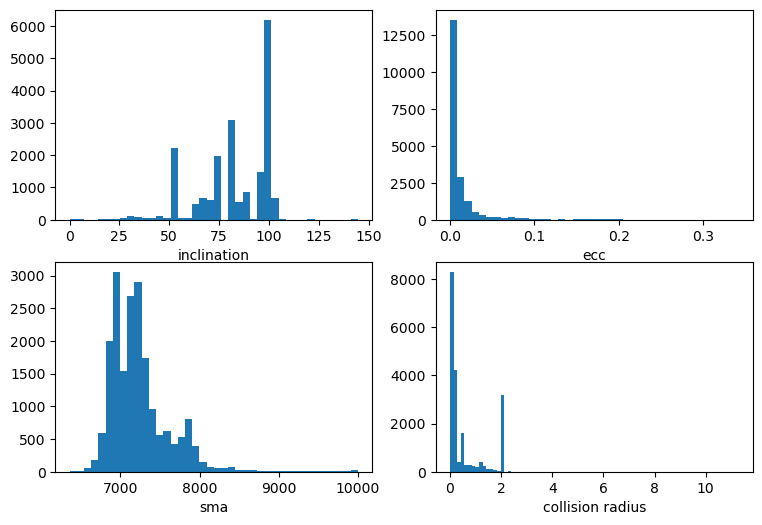

In [10]:
radius = []
for idx in to_satcat_index:
    radius.append(satcat[idx]["RADIUS"])

fig, axes = plt.subplots(2,2, figsize = (9,6))
axes[0,0].hist(incl, bins=40)
axes[0,0].set_xlabel("inclination")

axes[1,0].hist(sma, bins=40)
axes[1,0].set_xlabel("sma")

axes[0,1].hist(ecc, bins=40)
axes[0,1].set_xlabel("ecc")

axes[1,1].hist(radius, bins=80)
axes[1,1].set_xlabel("collision radius")

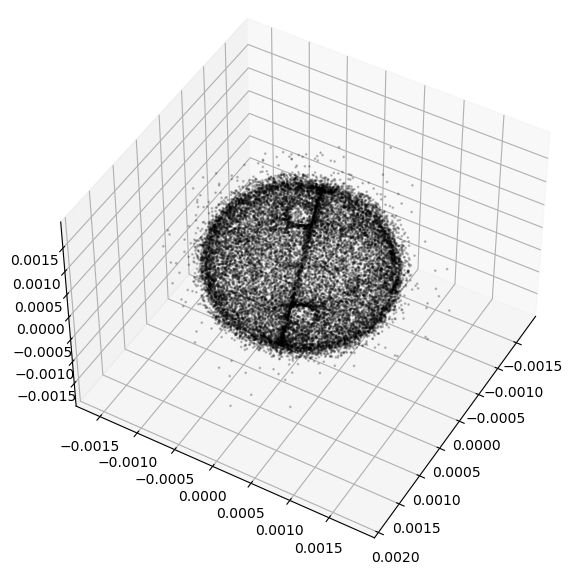

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(r[:,0]/pk.EARTH_RADIUS, r[:,1]/pk.EARTH_RADIUS, r[:,2]/pk.EARTH_RADIUS, alpha=0.2, s= 1, c='k')
ax.view_init(45,30)

Finally we can save all the information into an archive.

In [12]:
with open("data/leo_population.pk", "wb") as file:
    pkl.dump((r,v,to_satcat_index,satcat), file)